<a href="https://colab.research.google.com/github/sultanbst123/Titanic_Survived-Prediction-/blob/main/Titanic_survived_prediction(modeling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

In [ ]:
!pip install borutashap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from BorutaShap import BorutaShap
 
# classification
import xgboost, lightgbm, catboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
 
# regression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            log_loss, roc_auc_score, plot_roc_curve) 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
 
import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Titanic survival/train_titanic(clean).csv")
test = pd.read_csv("/content/drive/MyDrive/Titanic survival/test_titanic(clean).csv")
sub = pd.read_csv("/content/drive/MyDrive/Titanic survival/gender_submission.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Survived       891 non-null    int64 
 1   Pclass         891 non-null    int64 
 2   Sex            891 non-null    object
 3   Embarked       891 non-null    object
 4   title_name     891 non-null    object
 5   ticket_counts  891 non-null    int64 
 6   has_cabin      891 non-null    object
 7   age_bin        891 non-null    object
 8   Family_size    891 non-null    object
 9   isalone        891 non-null    object
 10  cut_fare       891 non-null    object
 11  Deck           891 non-null    object
dtypes: int64(3), object(9)
memory usage: 83.7+ KB


In [ ]:
train.head()

,Survived,Pclass,Sex,Embarked,title_name,ticket_counts,has_cabin,age_bin,Family_size,isalone,cut_fare,Deck
0,0,3,male,S,Mr,1,No,20-40,Small,No,low,M
1,1,1,female,C,Mrs,1,Yes,20-40,Small,No,high,ABC
2,1,3,female,S,Miss,1,No,20-40,Alone,Yes,low,M
3,1,1,female,S,Mrs,2,Yes,20-40,Small,No,high,ABC
4,0,3,male,S,Mr,1,No,20-40,Alone,Yes,low,M


In [ ]:
train_cp = train.copy()
test_cp = test.copy()

In [ ]:
x = train_cp.drop("Survived", axis=1) 
y = train_cp.Survived 
tester = test_cp

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=20)
 
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((712, 11), (179, 11), (712,), (179,))

#Feature Selection

In [ ]:
#ubah type object ke category 
 
cater = x.select_dtypes(exclude="number").columns

In [ ]:
x_train[cater] = x_train[cater].astype("category")
x_val[cater] = x_val[cater].astype("category") 
x_train.dtypes

Pclass              int64
Sex              category
Embarked         category
title_name       category
ticket_counts       int64
has_cabin        category
age_bin          category
Family_size      category
isalone          category
cut_fare         category
Deck             category
dtype: object

In [ ]:
lg = LGBMClassifier(objective="binary",is_unbalanced=True, random_state=10)

In [ ]:
#feature selection
Feature_Selector = BorutaShap(model=lg,
                                  importance_measure='shap', 
                                  classification=True)#set True jika classification

In [ ]:
Feature_Selector.fit(X=x_train, y=y_train, n_trials=50, random_state=0)

  0%|          | 0/50 [00:00<?, ?it/s]

4 attributes confirmed important: ['Pclass', 'title_name', 'Sex', 'cut_fare']
7 attributes confirmed unimportant: ['has_cabin', 'ticket_counts', 'isalone', 'Deck', 'Embarked', 'age_bin', 'Family_size']
0 tentative attributes remains: []


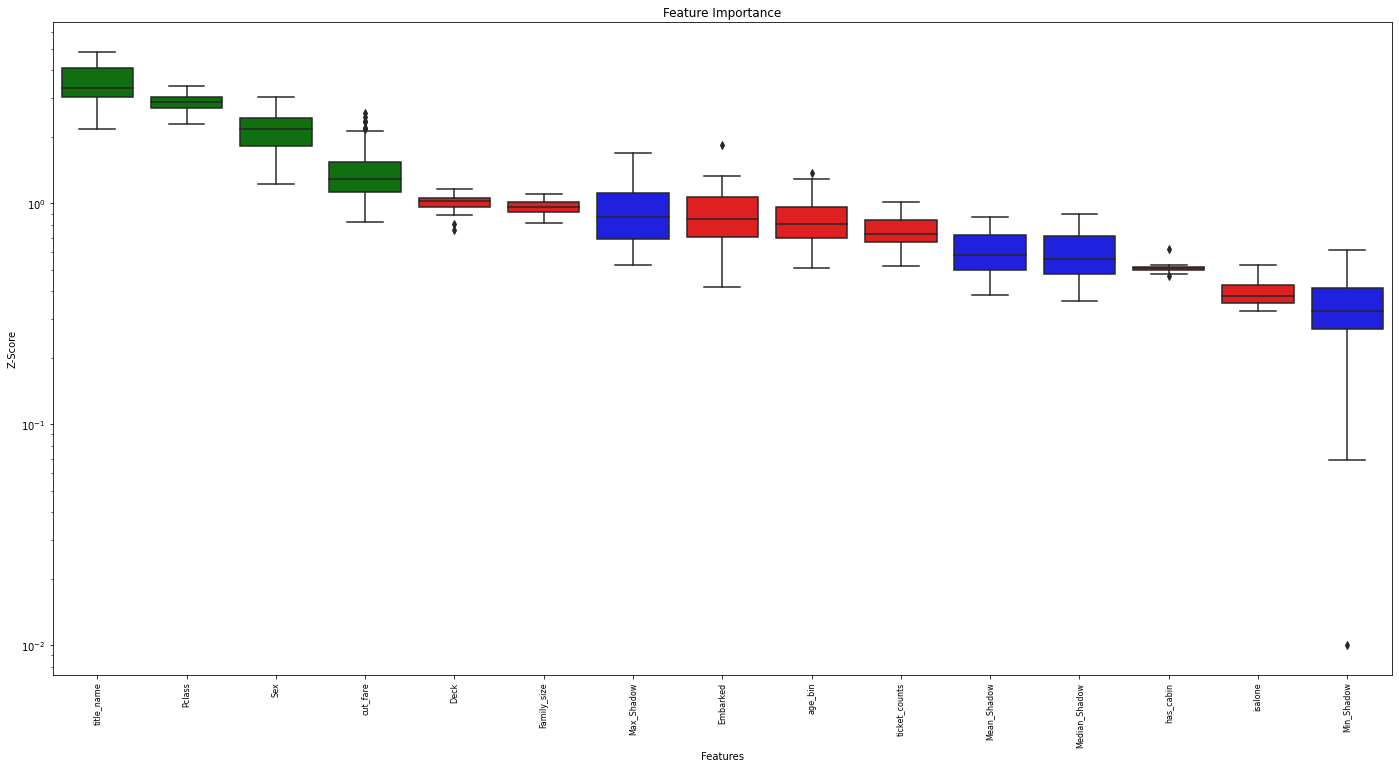

In [ ]:
Feature_Selector.plot(which_features='all', figsize=(24,12))

In [ ]:
col = Feature_Selector.Subset().columns

In [ ]:
acc_val = []
acc_train = []
roc_auc = []
loss = []

#model 1

In [ ]:
x_train_1 = x_train[col]
x_val_1 = x_val[col]

In [ ]:
x_train_1

,Pclass,title_name,Sex,cut_fare
811,3,Mr,male,medium
29,3,Mr,male,low
49,3,Mrs,female,medium
105,3,Mr,male,low
616,3,Mr,male,medium
...,...,...,...,...
218,1,Miss,female,high
223,3,Mr,male,low
271,3,Mr,male,low
474,3,Miss,female,medium


In [ ]:
x_train_1.shape, x_val_1.shape

((712, 4), (179, 4))

In [ ]:
lc = LabelEncoder()
for i in ["cut_fare", "title_name", "Sex"]: 
    x_train_1[i] = lc.fit_transform(x_train_1[i])
    x_val_1[i] = lc.transform(x_val_1[i])

In [ ]:
x_train_1.dtypes

Sex           int64
Pclass        int64
title_name    int64
cut_fare      int64
dtype: object

In [ ]:
gbc = GradientBoostingClassifier(random_state=10)
ada = AdaBoostClassifier(random_state=10)
xg = XGBClassifier(random_state=10)
rf = RandomForestClassifier(random_state=10)
dt = DecisionTreeClassifier(random_state=10)

In [ ]:
def score_1(model,x_train, y_train, x_val, y_val):
    #fit model
    model.fit(x_train,y_train)
 
    #accuracy train dan val
    acc_train.append(model.score(x_train, y_train))
    acc_val.append(model.score(x_val, y_val))
    
    #roc auc score
    pred = model.predict(x_val)
    rocauc = roc_auc_score(y_val, pred) 
    roc_auc.append(rocauc)
   
    #log_loss 
    prob = model.predict_proba(x_val) 
    logloss = log_loss(y_val, prob)
    loss.append(logloss)
    
 
    return model

In [ ]:
for i,j in enumerate([gbc,ada,xg,rf,dt]):
    score_1(j,x_train_1,y_train,x_val_1,y_val)
    print(i+1,"Done")

1 Done
2 Done
3 Done
4 Done
5 Done


#model_2

In [ ]:
x_train_2 = x_train[col]
x_val_2 = x_val[col]
x_train_2.shape, x_val_2.shape

((712, 4), (179, 4))

In [ ]:
x_train_2.head()

,Pclass,title_name,Sex,cut_fare
811,3,Mr,male,medium
29,3,Mr,male,low
49,3,Mrs,female,medium
105,3,Mr,male,low
616,3,Mr,male,medium


In [ ]:
x_train_2.dtypes

Sex           category
Pclass           int64
title_name    category
cut_fare      category
dtype: object

In [ ]:
cater = ["cut_fare", "title_name", "Sex"]
x_train_2[cater] = x_train_2[cater].astype("category")
x_val_2[cater] = x_val_2[cater].astype("category")

In [ ]:
lgbm = LGBMClassifier(is_unbalanced=True,random_state=10)
cb = CatBoostClassifier(scale_pos_weight=1,random_state=10)

In [ ]:
def score_2(model,x_train, y_train, x_val, y_val):
       
    #lgbm
    if model == lgbm:
       #fit model
       model.fit(x_train,y_train,verbose=False)
 
       #accuracy train dan val
       acc_train.append(model.score(x_train, y_train))
       acc_val.append(model.score(x_val, y_val))
     
       #roc auc score
       pred = model.predict(x_val)
       rocauc = roc_auc_score(y_val, pred) 
       roc_auc.append(rocauc)
   
       #log_loss 
       prob = model.predict_proba(x_val) 
       logloss = log_loss(y_val, prob)
       loss.append(logloss)
 
   #catboost
    else:         
       model.fit(x_train,y_train,cat_features=cater,verbose=False)
 
       #accuracy train dan val
       acc_train.append(model.score(x_train, y_train))
       acc_val.append(model.score(x_val, y_val))
    
       #roc auc score
       pred = model.predict(x_val)
       rocauc = roc_auc_score(y_val, pred)
       roc_auc.append(rocauc)
   
       #log_loss 
       prob = model.predict_proba(x_val)
       logloss = log_loss(y_val, prob)
       loss.append(logloss) 
    return model

In [ ]:
for i,j in enumerate([lgbm,cb]):    
    score_2(j,x_train_2, y_train, x_val_2, y_val)
    print(i+1, "Done")

1 Done
2 Done


#model_3

In [ ]:
x_train_3 = x_train[col]
x_val_3 = x_val[col]
x_train_3.shape, x_val_3.shape

((712, 4), (179, 4))

In [ ]:
x_train_3.dtypes

Sex           category
title_name    category
cut_fare      category
Pclass           int64
dtype: object

In [ ]:
x_train_3 = x_train_3.join(pd.get_dummies(x_train_3[cater])) 
x_val_3 = x_val_3.join(pd.get_dummies(x_val_3[cater]))

In [ ]:
for i in [x_train_3, x_val_3]: 
    i.drop(cater,axis = 1,inplace=True)

In [ ]:
x_train_3

,Pclass,cut_fare_high,cut_fare_low,cut_fare_medium,title_name_Master,title_name_Miss,title_name_Mr,title_name_Mrs,title_name_Other,Sex_female,Sex_male
811,3,0,0,1,0,0,1,0,0,0,1
29,3,0,1,0,0,0,1,0,0,0,1
49,3,0,0,1,0,0,0,1,0,1,0
105,3,0,1,0,0,0,1,0,0,0,1
616,3,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
218,1,1,0,0,0,1,0,0,0,1,0
223,3,0,1,0,0,0,1,0,0,0,1
271,3,0,1,0,0,0,1,0,0,0,1
474,3,0,0,1,0,1,0,0,0,1,0


In [ ]:
# Scale Value
sc = StandardScaler()
 
x_train_3 = sc.fit_transform(x_train_3)
x_val_3 = sc.transform(x_val_3)

In [ ]:
svc = SVC(kernel = "linear",random_state=10, probability=True)
lr = LogisticRegression(random_state=10)
knc = KNeighborsClassifier()

In [ ]:
def score_3(model,x_train, y_train, x_val, y_val):
    #fit model
    model.fit(x_train,y_train)
 
    #accuracy train dan val
    acc_train.append(model.score(x_train, y_train))
    acc_val.append(model.score(x_val, y_val))
    
    #roc auc score
    pred = model.predict(x_val)
    rocauc = roc_auc_score(y_val, pred) 
    roc_auc.append(rocauc)
   
    #log_loss 
    prob = model.predict_proba(x_val) 
    logloss = log_loss(y_val, prob)
    loss.append(logloss)
    
 
    return model

In [ ]:
for i,j in enumerate([svc,lr,knc]):
   score_3(j,x_train_3, y_train, x_val_3, y_val)
   print(i+1, "Done")

1 Done
2 Done
3 Done


#model selection

In [ ]:
dic = {"model": ["GBC","ADA","RF","DT","XG","LGBM","CB","SVC","LR","KNC"], 
      "accuracy_train": acc_train, 
      "accuracy_val":acc_val, 
      "roc_auc_score": roc_auc, 
      "log_loss": loss}

In [ ]:
df_model = pd.DataFrame(dic)

In [ ]:
df_model  = df_model.set_index("model")
df_model

,accuracy_train,accuracy_val,roc_auc_score,log_loss
model,,,,
GBC,0.824438,0.826816,0.783649,0.389978
ADA,0.783708,0.832402,0.815099,0.679891
RF,0.824438,0.826816,0.783649,0.393738
DT,0.824438,0.826816,0.783649,0.389685
XG,0.824438,0.826816,0.783649,0.388846
LGBM,0.824438,0.826816,0.783649,0.391306
CB,0.824438,0.826816,0.783649,0.399674
SVC,0.783708,0.832402,0.815099,0.459664
LR,0.801966,0.871508,0.846349,0.409031


<Figure size 1224x576 with 0 Axes>

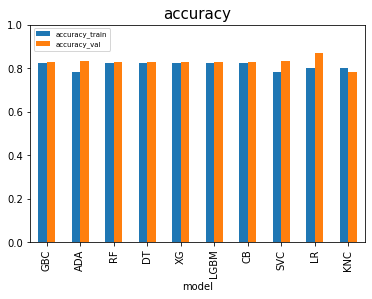

In [ ]:
 
plt.figure(figsize=(17,8)) 
df_model[["accuracy_train", "accuracy_val"]].plot.bar()
plt.title("accuracy", size=15)
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0],size=10)
plt.xticks(size=10)
plt.legend(loc=2,fontsize=7)
plt.show()

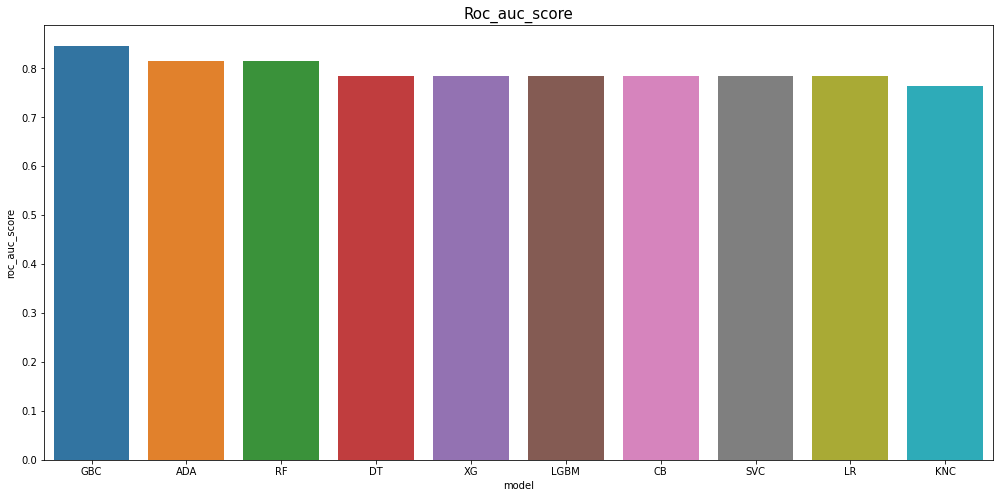

In [ ]:
plt.figure(figsize=(17,8)) 
sns.barplot(x=df_model.index,y="roc_auc_score",data=df_model.sort_values("roc_auc_score",ascending=False))
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("Roc_auc_score", size=15)
plt.show()

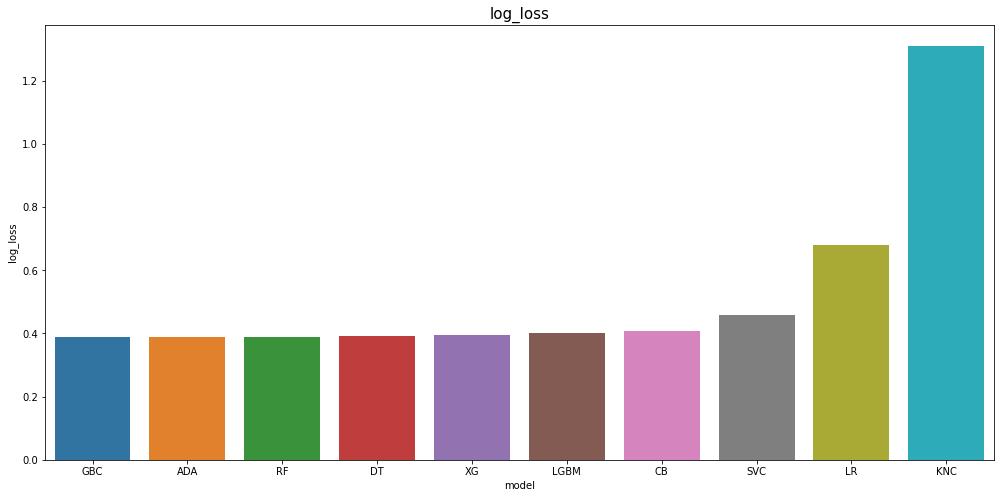

In [ ]:
plt.figure(figsize=(17,8)) 
sns.barplot(x=df_model.index,y="log_loss",data=df_model.sort_values("log_loss"))
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("log_loss", size=15)
plt.show()

#Hyperparameters tuning

In [ ]:
def objective(trial):
    
    params = {
        "solver" : trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        "C" : trial.suggest_categorical("C",[100, 10, 1.0, 0.1, 0.01])       
        }
    model = LogisticRegression(**params, random_state=42)
    model.fit(x_train_3,y_train)
 
    y_preds = model.predict(x_val_3) 
    score = accuracy_score(y_val,y_preds)
    
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2021-09-25 04:08:13,041] A new study created in memory with name: no-name-6fcd68a2-5a00-4ccf-88ae-5955c085db31
[I 2021-09-25 04:08:13,050] Trial 0 finished with value: 0.8435754189944135 and parameters: {'solver': 'saga', 'C': 0.1}. Best is trial 0 with value: 0.8435754189944135.
[I 2021-09-25 04:08:13,062] Trial 1 finished with value: 0.8435754189944135 and parameters: {'solver': 'liblinear', 'C': 0.1}. Best is trial 0 with value: 0.8435754189944135.
[I 2021-09-25 04:08:13,082] Trial 2 finished with value: 0.8715083798882681 and parameters: {'solver': 'sag', 'C': 100}. Best is trial 2 with value: 0.8715083798882681.
[I 2021-09-25 04:08:13,091] Trial 3 finished with value: 0.8435754189944135 and parameters: {'solver': 'sag', 'C': 0.01}. Best is trial 2 with value: 0.8715083798882681.
[I 2021-09-25 04:08:13,108] Trial 4 finished with value: 0.8715083798882681 and parameters: {'solver': 'newton-cg', 'C': 1.0}. Best is trial 2 with value: 0.8715083798882681.
[I 2021-09-25 04:08:13,132]

In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 50
Best trial: {'solver': 'sag', 'C': 100}


#Cross validation

In [ ]:
def cross_val(X, y, model, params, folds=5):

    score = []
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
 
        alg = model(**params)
        alg.fit(x_train, y_train)
 
        pred = alg.predict(x_test)
        loss = accuracy_score(y_test, pred)
        score.append(loss)

        print(f" accuracy_score: {loss}")
        print("-"*50)
     
    print("mean:",np.array(score).mean())

    return alg

In [ ]:
x_train_3.shape, x_val_3.shape

((712, 11), (179, 11))

In [ ]:
#buat target Dan feature baru
X_new = pd.DataFrame(np.concatenate([x_train_3,x_val_3]))
Y_new = pd.concat([y_train, y_val])

In [ ]:
#pilih param terbaik
lr_params = study.best_trial.params
lr_params

{'C': 100, 'solver': 'sag'}

In [ ]:
score = cross_val(X_new,Y_new,LogisticRegression, lr_params)

Fold: 0
 accuracy_score: 0.7932960893854749
--------------------------------------------------
Fold: 1
 accuracy_score: 0.848314606741573
--------------------------------------------------
Fold: 2
 accuracy_score: 0.8314606741573034
--------------------------------------------------
Fold: 3
 accuracy_score: 0.7752808988764045
--------------------------------------------------
Fold: 4
 accuracy_score: 0.7696629213483146
--------------------------------------------------
mean: 0.8036030381018142


In [ ]:
#x_val_3 karena saya pilih logisticregression 
y_true = score.predict(x_val_3)

In [ ]:
accuracy_score(y_val,y_true)

0.8491620111731844

In [ ]:
classification_report(y_val, y_true)

'              precision    recall  f1-score   support\n\n           0       0.83      0.96      0.89       112\n           1       0.90      0.67      0.77        67\n\n    accuracy                           0.85       179\n   macro avg       0.86      0.81      0.83       179\nweighted avg       0.86      0.85      0.84       179\n'

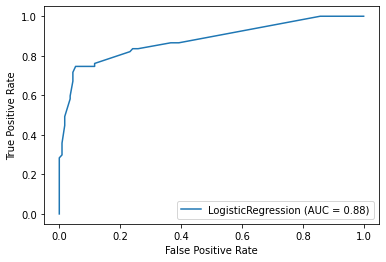

In [ ]:
plot_roc_curve(score, x_val_3, y_val)

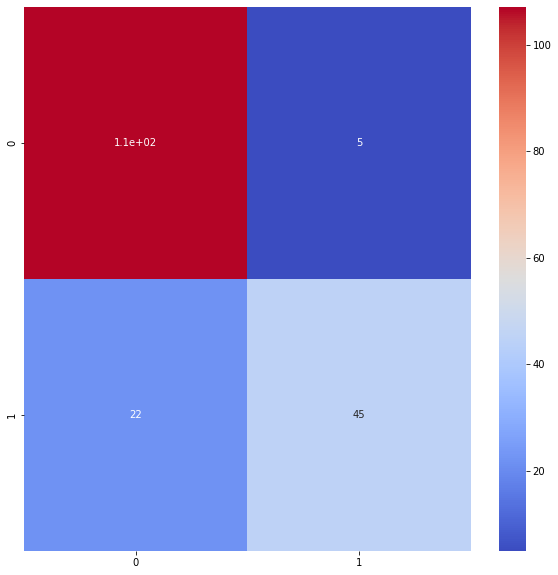

In [ ]:
cf = confusion_matrix(y_val, y_true)

plt.figure(figsize=(10,10)) 
sns.heatmap(cf, annot=True,cmap="coolwarm")

#predict for unseen data

In [ ]:
tester = tester[col]
tester = tester.join(pd.get_dummies(tester[cater]))

In [ ]:
tester.drop(["Sex", "title_name", "cut_fare"], axis=1, inplace=True)

In [ ]:
tester = sc.transform(tester)

In [ ]:
preds = score.predict(tester)

In [ ]:
print(f"accuracy: {accuracy_score(sub.iloc[:,-1],preds)}")

accuracy: 0.9473684210526315


#final submission

In [ ]:
sub["Survived"] = preds

In [ ]:
sub

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
sub.to_csv("my_subs.csv", index=False)